### Двумерное уравнение теплопроводности

In [24]:
x = [[pi, 2*pi, 3*pi], [4*pi, 5*pi, 6*pi]]
y = [4*pi, 5*pi, 6*pi]
np.sin(x)

array([[  1.22464680e-16,  -2.44929360e-16,   3.67394040e-16],
       [ -4.89858720e-16,   6.12323400e-16,  -7.34788079e-16]])

In [96]:
from math import cos, sin, pi, exp
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [27]:
exp(1)

2.718281828459045

In [88]:
Nx, Ny = 100, 100
delta_t = 1e-2
t_max = 10
Alpha = np.array([1, 2, 5, 100])
lambda_x = 1e-4
Lambda_y = Alpha * lambda_x

In [113]:
def fi(x_range, y, t, lambda_y):
#     print(lambda_x, lambda_y, t)
#     print
    return np.cos(x_range * pi) * sin(pi * y) * exp(-(lambda_x + lambda_y) * t * (pi**2))

In [114]:
x_range, y_range = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)

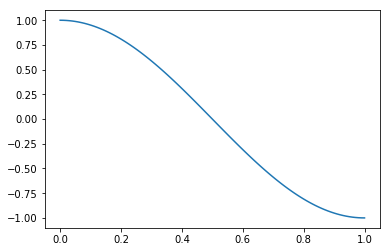

In [115]:
plt.plot(x_range, fi(x_range, 1/2, 0, 0))

In [116]:
print(list(i**2 for i in range(10)))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [117]:
# fi_matrix = np.zeros((Nx, Ny))
fi_matrix = np.matrix([fi(x_range, y, 0, Lambda_y[0]) for y in y_range])

In [137]:
print(fi_matrix.max())

0.999874127674


In [124]:
h_step, tau_step = 1 / 100, 1 / 100
gamma = 1 / tau_step 

In [134]:
c, b = lambda_x / (h_step ** 2), lambda_x / (h_step ** 2)
g, f = Lambda_y[0] / (h_step ** 2), Lambda_y[0] / (h_step ** 2)
a = -(c + b + g + f) + gamma

In [135]:
print(a, c, b, g, f)

96.0 1.0 1.0 1.0 1.0


In [136]:
d_matrix = - gamma * fi_matrix 

In [138]:
prev_fi = fi
while(True):
    fi = [d_matrix[raw, col] - 

SyntaxError: unexpected EOF while parsing (<ipython-input-138-8d3dd0e7a185>, line 2)